In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import chi2_contingency
import warnings
warnings.filterwarnings('ignore')

In [13]:
df_1 = pd.read_csv("data/acsee_results_2023.csv")
df_2 = pd.read_csv("data/acsee_results_2024.csv")

In [14]:
df_1 = df_1[ ~df_1.gpa.isnull() ]
df_1.rename({'gpa':'prev_gpa'},axis=1,inplace=True)

In [15]:
df_2 = df_2[ ~df_2.gpa.isnull() ]

In [16]:
df_3 = pd.read_csv("project_school_performance_data(2023).csv")

In [17]:
df_3 = df_3[ ~df_3.GPA.isnull() ]
df_3.rename({'SCHOOL':'school_code','GPA':'prev_gpa','NUMBER OF CANDIDATES':'prev_enroll','SAT FOR EXAM':'prev_sat'},axis=1,inplace=True)

In [4]:
# df = pd.concat([df_3.set_index('school_code'),df_2.set_index('school_code')], axis=1)
df = pd.read_csv("data/df_.csv")

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 178 entries, 0 to 177
Data columns (total 17 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   school_code              178 non-null    object 
 1   prev_sat                 178 non-null    float64
 2   SCHOOL OWNERSHIP         178 non-null    object 
 3   SCHOOL CATEGORY          178 non-null    object 
 4   SCHOOL TYPE              173 non-null    object 
 5   COMBINATIONS CATEGORY    167 non-null    object 
 6   ACADEMIC LEVEL CATEGORY  167 non-null    object 
 7   prev_gpa                 177 non-null    float64
 8   gpa                      178 non-null    float64
 9   sat                      178 non-null    float64
 10  STUDENTS                 178 non-null    float64
 11  TEACHERS                 178 non-null    float64
 12  STUDENT-TEACHER RATIO    178 non-null    object 
 13  student_teacher_ratio    178 non-null    float64
 14  studying_hours           1

In [6]:
df.isnull().sum()

school_code                 0
prev_sat                    0
SCHOOL OWNERSHIP            0
SCHOOL CATEGORY             0
SCHOOL TYPE                 5
COMBINATIONS CATEGORY      11
ACADEMIC LEVEL CATEGORY    11
prev_gpa                    1
gpa                         0
sat                         0
STUDENTS                    0
TEACHERS                    0
STUDENT-TEACHER RATIO       0
student_teacher_ratio       0
studying_hours              0
number_of_books             0
teacher_qualification       0
dtype: int64

In [7]:
df.describe()

,prev_sat,prev_gpa,gpa,sat,STUDENTS,TEACHERS,student_teacher_ratio,studying_hours,number_of_books
count,178.000000,177.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000
mean,113.084270,2.560664,2.456174,117.404494,661.123596,40.022472,16.451816,99.314844,538.702247
std,126.447232,0.497044,0.470863,129.341725,433.651252,19.455572,5.631726,27.599192,132.094283
min,1.000000,1.289100,1.365700,2.000000,144.000000,10.000000,8.947368,7.804424,40.000000
25%,29.250000,2.244400,2.136675,31.000000,400.000000,30.000000,12.500000,79.837082,460.250000
50%,63.000000,2.618800,2.404600,73.500000,545.000000,35.000000,15.058140,99.351690,532.500000
75%,142.250000,2.853700,2.760550,147.750000,800.000000,50.000000,19.933333,117.747282,616.750000
max,676.000000,3.654600,3.738100,585.000000,3500.000000,115.000000,41.860465,166.325219,877.000000


In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import chi2_contingency
import warnings
warnings.filterwarnings('ignore')

# Set plotting style
plt.style.use('default')
sns.set_palette("husl")

# ==========================================
# STEP 1: DATA PREPARATION & CLEANING
# ==========================================

def prepare_data(df):
    """
    Clean and prepare data for EDA
    """
    print("=== STEP 1: DATA PREPARATION ===")
    
    # Create a copy to work with
    df_clean = df.copy()
    
    # Convert object columns to numeric where appropriate
    numeric_cols = ['prev_gpa', 'STUDENTS', 'TEACHERS', 'STUDENT-TEACHER RATIO', 'studying_hours', 'teacher_qualification', 'number_of_books']
    
    for col in numeric_cols:
        if col in df_clean.columns:
            print(f"Converting {col} to numeric...")
            original_type = df_clean[col].dtype
            df_clean[col] = pd.to_numeric(df_clean[col], errors='coerce')
            print(f"  {col}: {original_type} -> {df_clean[col].dtype}")
    
    # Focus on the variables for modeling
    model_vars = ['prev_sat', 'SCHOOL OWNERSHIP', 'SCHOOL CATEGORY', 'SCHOOL TYPE',
                  'COMBINATIONS CATEGORY', 'ACADEMIC LEVEL CATEGORY', 'prev_gpa', 
                  'gpa', 'sat', 'STUDENTS', 'TEACHERS', 'STUDENT-TEACHER RATIO', 'studying_hours', 'teacher_qualification', 'number_of_books']
    
    # Only include variables that exist in the dataset
    available_vars = [var for var in model_vars if var in df_clean.columns]
    missing_vars = [var for var in model_vars if var not in df_clean.columns]
    
    if missing_vars:
        print(f"\nWarning: These variables are not in the dataset: {missing_vars}")
    
    # Create subset with available model variables
    df_model = df_clean[available_vars].copy()
    
    print(f"Original dataset shape: {df.shape}")
    print(f"Model variables dataset shape: {df_model.shape}")
    print(f"Available variables: {available_vars}")
    print("\nMissing values in model variables:")
    missing_summary = df_model.isnull().sum().sort_values(ascending=False)
    print(missing_summary[missing_summary > 0])
    
    return df_model

# ==========================================
# STEP 2: TARGET VARIABLE ANALYSIS
# ==========================================

def analyze_target_variable(df, target='gpa'):
    """
    Comprehensive analysis of the target variable (GPA)
    """
    print(f"\n=== STEP 2: TARGET VARIABLE ANALYSIS ({target.upper()}) ===")
    
    # Basic statistics
    print(f"\n{target.upper()} Descriptive Statistics:")
    print(df[target].describe())
    
    # Check for outliers using IQR method
    Q1 = df[target].quantile(0.25)
    Q3 = df[target].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    outliers = df[(df[target] < lower_bound) | (df[target] > upper_bound)]
    print(f"\nOutliers detected: {len(outliers)} ({len(outliers)/len(df)*100:.1f}%)")
    print(f"Outlier range: < {lower_bound:.3f} or > {upper_bound:.3f}")
    
    # Distribution analysis
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    fig.suptitle(f'{target.upper()} Distribution Analysis', fontsize=16)
    
    # Histogram
    axes[0,0].hist(df[target].dropna(), bins=30, alpha=0.7, color='skyblue', edgecolor='black')
    axes[0,0].axvline(df[target].mean(), color='red', linestyle='--', label=f'Mean: {df[target].mean():.3f}')
    axes[0,0].axvline(df[target].median(), color='green', linestyle='--', label=f'Median: {df[target].median():.3f}')
    axes[0,0].set_title('Histogram')
    axes[0,0].set_xlabel(target.upper())
    axes[0,0].set_ylabel('Frequency')
    axes[0,0].legend()
    
    # Box plot
    axes[0,1].boxplot(df[target].dropna())
    axes[0,1].set_title('Box Plot')
    axes[0,1].set_ylabel(target.upper())
    
    # Q-Q plot for normality
    stats.probplot(df[target].dropna(), dist="norm", plot=axes[1,0])
    axes[1,0].set_title('Q-Q Plot (Normality Check)')
    
    # Density plot
    df[target].dropna().plot(kind='density', ax=axes[1,1], color='purple')
    axes[1,1].set_title('Density Plot')
    axes[1,1].set_xlabel(target.upper())
    
    plt.tight_layout()
    plt.show()
    
    # Normality tests
    shapiro_stat, shapiro_p = stats.shapiro(df[target].dropna().sample(min(5000, len(df[target].dropna()))))
    print(f"\nNormality Tests:")
    print(f"Shapiro-Wilk p-value: {shapiro_p:.6f}")
    print(f"Distribution is {'Normal' if shapiro_p > 0.05 else 'Not Normal'} (α = 0.05)")
    
    return df[target].describe()

# ==========================================
# STEP 3: NUMERICAL VARIABLES ANALYSIS
# ==========================================

def analyze_numerical_variables(df, target='gpa'):
    """
    Analyze numerical predictor variables
    """
    print(f"\n=== STEP 3: NUMERICAL VARIABLES ANALYSIS ===")
    
    # Identify numerical columns
    # numerical_cols = df.select_dtypes(include=[np.number]).columns.tolist()
    numerical_cols = ['prev_gpa', 'STUDENTS', 'TEACHERS', 'STUDENT-TEACHER RATIO', 'studying_hours', 'teacher_qualification', 'number_of_books']
    if target in numerical_cols:
        numerical_cols.remove(target)
    
    print(f"Numerical variables: {numerical_cols}")
    
    # Correlation analysis
    print(f"\n3.1 CORRELATION ANALYSIS:")
    corr_with_target = df[numerical_cols + [target]].corr()[target].drop(target).sort_values(key=abs, ascending=False)
    print(f"Correlation with {target.upper()}:")
    for var, corr in corr_with_target.items():
        print(f"  {var}: {corr:.3f}")
    
    # Correlation heatmap
    plt.figure(figsize=(10, 8))
    correlation_matrix = df[numerical_cols + [target]].corr()
    mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, 
                mask=mask, square=True, fmt='.3f')
    plt.title('Correlation Matrix')
    plt.tight_layout()
    plt.show()
    
    # Scatter plots with target
    if len(numerical_cols) > 0:
        n_cols = min(3, len(numerical_cols))
        n_rows = (len(numerical_cols) + n_cols - 1) // n_cols
        
        fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5*n_rows))
        if n_rows == 1:
            axes = [axes] if n_cols == 1 else axes
        else:
            axes = axes.flatten()
        
        for i, col in enumerate(numerical_cols):
            if i < len(axes):
                # Remove outliers for better visualization
                data_clean = df[[col, target]].dropna()
                Q1_x = data_clean[col].quantile(0.05)
                Q3_x = data_clean[col].quantile(0.95)
                Q1_y = data_clean[target].quantile(0.05)
                Q3_y = data_clean[target].quantile(0.95)
                
                mask = ((data_clean[col] >= Q1_x) & (data_clean[col] <= Q3_x) & 
                       (data_clean[target] >= Q1_y) & (data_clean[target] <= Q3_y))
                data_plot = data_clean[mask]
                
                axes[i].scatter(data_plot[col], data_plot[target], alpha=0.6)
                axes[i].set_xlabel(col)
                axes[i].set_ylabel(target.upper())
                axes[i].set_title(f'{col} vs {target.upper()}\nCorr: {corr_with_target[col]:.3f}')
                
                # Add trend line
                if len(data_plot) > 1:
                    z = np.polyfit(data_plot[col], data_plot[target], 1)
                    p = np.poly1d(z)
                    axes[i].plot(data_plot[col], p(data_plot[col]), "r--", alpha=0.8)
        
        # Hide empty subplots
        for i in range(len(numerical_cols), len(axes)):
            axes[i].set_visible(False)
        
        plt.suptitle(f'Numerical Variables vs {target.upper()}', fontsize=16)
        plt.tight_layout()
        plt.show()
    
    return corr_with_target

# ==========================================
# STEP 4: CATEGORICAL VARIABLES ANALYSIS
# ==========================================

def analyze_categorical_variables(df, target='gpa'):
    """
    Analyze categorical predictor variables
    """
    print(f"\n=== STEP 4: CATEGORICAL VARIABLES ANALYSIS ===")
    
    # Identify categorical columns
    categorical_cols = df.select_dtypes(include=['object']).columns.tolist()
    print(f"Categorical variables: {categorical_cols}")
    
    for col in categorical_cols:
        print(f"\n4.{categorical_cols.index(col)+1} ANALYSIS OF {col.upper()}:")
        
        # Value counts
        value_counts = df[col].value_counts()
        print(f"Categories ({len(value_counts)} unique):")
        print(value_counts.head(10))  # Show top 10
        
        # Missing values
        missing_pct = df[col].isnull().sum() / len(df) * 100
        print(f"Missing values: {df[col].isnull().sum()} ({missing_pct:.1f}%)")
        
        # Statistical test (ANOVA for categorical vs numerical)
        if not df[col].isnull().all():
            try:
                groups = [group[target].dropna() for name, group in df.groupby(col) if len(group) > 1]
                if len(groups) > 1 and all(len(group) > 0 for group in groups):
                    f_stat, p_value = stats.f_oneway(*groups)
                    print(f"ANOVA F-statistic: {f_stat:.3f}, p-value: {p_value:.6f}")
                    print(f"Significant difference: {'Yes' if p_value < 0.05 else 'No'} (α = 0.05)")
            except:
                print("Could not perform ANOVA test")
        
        # Box plot for each category
        plt.figure(figsize=(12, 6))
        
        # Filter out categories with very few observations for cleaner plot
        category_counts = df[col].value_counts()
        main_categories = category_counts[category_counts >= 5].index
        
        if len(main_categories) > 0:
            df_plot = df[df[col].isin(main_categories)]
            
            plt.subplot(1, 2, 1)
            sns.boxplot(data=df_plot, x=col, y=target)
            plt.xticks(rotation=45, ha='right')
            plt.title(f'{target.upper()} by {col}')
            
            plt.subplot(1, 2, 2)
            means = df_plot.groupby(col)[target].mean().sort_values(ascending=False)
            means.plot(kind='bar')
            plt.title(f'Mean {target.upper()} by {col}')
            plt.xticks(rotation=45, ha='right')
            plt.ylabel(f'Mean {target.upper()}')
        
        plt.tight_layout()
        plt.show()
        
        # Summary statistics by category
        summary_stats = df.groupby(col)[target].agg(['count', 'mean', 'std', 'min', 'max']).round(3)
        print(f"\nSummary statistics by {col}:")
        print(summary_stats.head(10))

# ==========================================
# STEP 5: MULTIVARIATE ANALYSIS
# ==========================================

def multivariate_analysis(df, target='gpa'):
    """
    Analyze relationships between multiple variables
    """
    print(f"\n=== STEP 5: MULTIVARIATE ANALYSIS ===")
    
    # 5.1 Correlation between predictors
    print("5.1 PREDICTOR CORRELATIONS:")
    numerical_predictors = df.select_dtypes(include=[np.number]).columns.tolist()
    if target in numerical_predictors:
        numerical_predictors.remove(target)
    
    if len(numerical_predictors) > 1:
        pred_corr = df[numerical_predictors].corr()
        
        # Find high correlations (potential multicollinearity)
        high_corr_pairs = []
        for i in range(len(pred_corr.columns)):
            for j in range(i+1, len(pred_corr.columns)):
                corr_val = pred_corr.iloc[i, j]
                if abs(corr_val) > 0.7:  # High correlation threshold
                    high_corr_pairs.append((pred_corr.columns[i], pred_corr.columns[j], corr_val))
        
        if high_corr_pairs:
            print("High correlations between predictors (|r| > 0.7):")
            for var1, var2, corr in high_corr_pairs:
                print(f"  {var1} - {var2}: {corr:.3f}")
        else:
            print("No high correlations between predictors detected.")
    
    # 5.2 Interaction effects (example with categorical variables)
    print("\n5.2 INTERACTION EFFECTS:")
    categorical_cols = df.select_dtypes(include=['object']).columns.tolist()
    
    if len(categorical_cols) >= 2:
        # Example: Analyze interaction between first two categorical variables
        cat1, cat2 = categorical_cols[0], categorical_cols[1]
        
        # Create interaction plots
        fig, axes = plt.subplots(1, 2, figsize=(15, 6))
        
        # Pivot table for interaction
        interaction_data = df.groupby([cat1, cat2])[target].agg(['mean', 'count']).reset_index()
        interaction_pivot = interaction_data.pivot_table(values='mean', index=cat1, columns=cat2, fill_value=np.nan)
        
        # Heatmap of interactions
        sns.heatmap(interaction_pivot, annot=True, fmt='.3f', ax=axes[0], cmap='viridis')
        axes[0].set_title(f'Mean {target.upper()}: {cat1} × {cat2}')
        
        # Interaction plot
        for cat2_val in df[cat2].dropna().unique()[:5]:  # Limit to first 5 categories
            subset = df[df[cat2] == cat2_val]
            if len(subset) > 0:
                means = subset.groupby(cat1)[target].mean()
                axes[1].plot(range(len(means)), means.values, marker='o', label=f'{cat2}: {cat2_val}')
        
        axes[1].set_xticks(range(len(means)))
        axes[1].set_xticklabels(means.index, rotation=45)
        axes[1].set_ylabel(f'Mean {target.upper()}')
        axes[1].set_title(f'{cat1} × {cat2} Interaction')
        axes[1].legend(bbox_to_anchor=(1.05, 1), loc='upper left')
        
        plt.tight_layout()
        plt.show()

# ==========================================
# STEP 6: DATA QUALITY ASSESSMENT
# ==========================================

def assess_data_quality(df, target='gpa'):
    """
    Comprehensive data quality assessment
    """
    print(f"\n=== STEP 6: DATA QUALITY ASSESSMENT ===")
    
    # 6.1 Missing data patterns
    print("6.1 MISSING DATA ANALYSIS:")
    missing_summary = pd.DataFrame({
        'Missing_Count': df.isnull().sum(),
        'Missing_Percentage': (df.isnull().sum() / len(df)) * 100
    }).sort_values('Missing_Count', ascending=False)
    
    print(missing_summary[missing_summary['Missing_Count'] > 0])
    
    # Missing data visualization
    if missing_summary['Missing_Count'].sum() > 0:
        plt.figure(figsize=(12, 6))
        
        plt.subplot(1, 2, 1)
        missing_cols = missing_summary[missing_summary['Missing_Count'] > 0].index
        sns.heatmap(df[missing_cols].isnull(), cbar=True, yticklabels=False, cmap='viridis')
        plt.title('Missing Data Pattern')
        
        plt.subplot(1, 2, 2)
        missing_summary[missing_summary['Missing_Count'] > 0]['Missing_Percentage'].plot(kind='bar')
        plt.title('Missing Data Percentage by Variable')
        plt.ylabel('Missing %')
        plt.xticks(rotation=45, ha='right')
        
        plt.tight_layout()
        plt.show()
    
    # 6.2 Outlier analysis
    print("\n6.2 OUTLIER ANALYSIS:")
    numerical_cols = df.select_dtypes(include=[np.number]).columns.tolist()
    
    outlier_summary = {}
    for col in numerical_cols:
        # Skip columns with no data or all missing values
        if df[col].dropna().empty:
            print(f"Skipping {col}: No valid data")
            continue
            
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        
        outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)]
        valid_count = len(df[col].dropna())
        
        outlier_summary[col] = {
            'count': len(outliers),
            'percentage': len(outliers) / valid_count * 100 if valid_count > 0 else 0,
            'valid_observations': valid_count
        }
    
    if outlier_summary:
        outlier_df = pd.DataFrame(outlier_summary).T
        print("Outliers by variable:")
        print(outlier_df.sort_values('percentage', ascending=False))
    else:
        print("No numerical variables with valid data found for outlier analysis.")
    
    return missing_summary, outlier_df

# ==========================================
# STEP 7: FEATURE ENGINEERING SUGGESTIONS
# ==========================================

def suggest_feature_engineering(df, target='gpa'):
    """
    Suggest feature engineering opportunities
    """
    print(f"\n=== STEP 7: FEATURE ENGINEERING SUGGESTIONS ===")
    
    print("7.1 POTENTIAL NEW FEATURES:")
    
    # Check if we have components to create ratios
    if 'STUDENTS' in df.columns and 'TEACHERS' in df.columns:
        print("- Student-Teacher ratio (if not already present)")
    
    if 'prev_sat' in df.columns and 'sat' in df.columns:
        print("- SAT improvement (current - previous)")
        print("- SAT improvement percentage")
    
    if 'prev_gpa' in df.columns:
        print("- GPA improvement (current - previous)")
        print("- GPA improvement percentage")
    
    print("\n7.2 TRANSFORMATION SUGGESTIONS:")
    
    # Check skewness of numerical variables
    numerical_cols = df.select_dtypes(include=[np.number]).columns.tolist()
    for col in numerical_cols:
        skewness = df[col].skew()
        if abs(skewness) > 1:
            transform_type = "log" if skewness > 1 else "square"
            print(f"- {col}: highly skewed ({skewness:.2f}), consider {transform_type} transformation")
    
    print("\n7.3 CATEGORICAL ENCODING SUGGESTIONS:")
    categorical_cols = df.select_dtypes(include=['object']).columns.tolist()
    
    for col in categorical_cols:
        unique_vals = df[col].nunique()
        if unique_vals <= 5:
            print(f"- {col}: {unique_vals} categories, suitable for one-hot encoding")
        else:
            print(f"- {col}: {unique_vals} categories, consider target encoding or frequency encoding")

# ==========================================
# MAIN EXECUTION FUNCTION
# ==========================================

def run_comprehensive_eda(df):
    """
    Run the complete EDA pipeline
    """
    print("COMPREHENSIVE EDA FOR GPA PREDICTION")
    print("=" * 50)
    
    # Step 1: Data Preparation
    df_model = prepare_data(df)
    
    # Step 2: Target Variable Analysis
    target_stats = analyze_target_variable(df_model, 'gpa')
    
    # Step 3: Numerical Variables Analysis
    correlations = analyze_numerical_variables(df_model, 'gpa')
    
    # Step 4: Categorical Variables Analysis
    analyze_categorical_variables(df_model, 'gpa')
    
    # Step 5: Multivariate Analysis
    multivariate_analysis(df_model, 'gpa')
    
    # Step 6: Data Quality Assessment
    missing_summary, outlier_summary = assess_data_quality(df_model, 'gpa')
    
    # Step 7: Feature Engineering Suggestions
    suggest_feature_engineering(df_model, 'gpa')
    
    print(f"\n{'='*50}")
    print("EDA COMPLETE!")
    print("Next steps: Data preprocessing and model building")
    
    return df_model

# ==========================================
# USAGE EXAMPLE
# ==========================================

# To run the complete EDA:
# df_clean = run_comprehensive_eda(df)

# To run individual steps:
# df_model = prepare_data(df)
# analyze_target_variable(df_model)
# analyze_numerical_variables(df_model)
# etc.

COMPREHENSIVE EDA FOR GPA PREDICTION
=== STEP 1: DATA PREPARATION ===
Converting prev_gpa to numeric...
  prev_gpa: float64 -> float64
Converting STUDENTS to numeric...
  STUDENTS: float64 -> float64
Converting TEACHERS to numeric...
  TEACHERS: float64 -> float64
Converting STUDENT-TEACHER RATIO to numeric...
  STUDENT-TEACHER RATIO: object -> float64
Converting studying_hours to numeric...
  studying_hours: float64 -> float64
Converting teacher_qualification to numeric...
  teacher_qualification: object -> float64
Converting number_of_books to numeric...
  number_of_books: int64 -> int64
Original dataset shape: (178, 17)
Model variables dataset shape: (178, 15)
Available variables: ['prev_sat', 'SCHOOL OWNERSHIP', 'SCHOOL CATEGORY', 'SCHOOL TYPE', 'COMBINATIONS CATEGORY', 'ACADEMIC LEVEL CATEGORY', 'prev_gpa', 'gpa', 'sat', 'STUDENTS', 'TEACHERS', 'STUDENT-TEACHER RATIO', 'studying_hours', 'teacher_qualification', 'number_of_books']

Missing values in model variables:
STUDENT-TEACHER

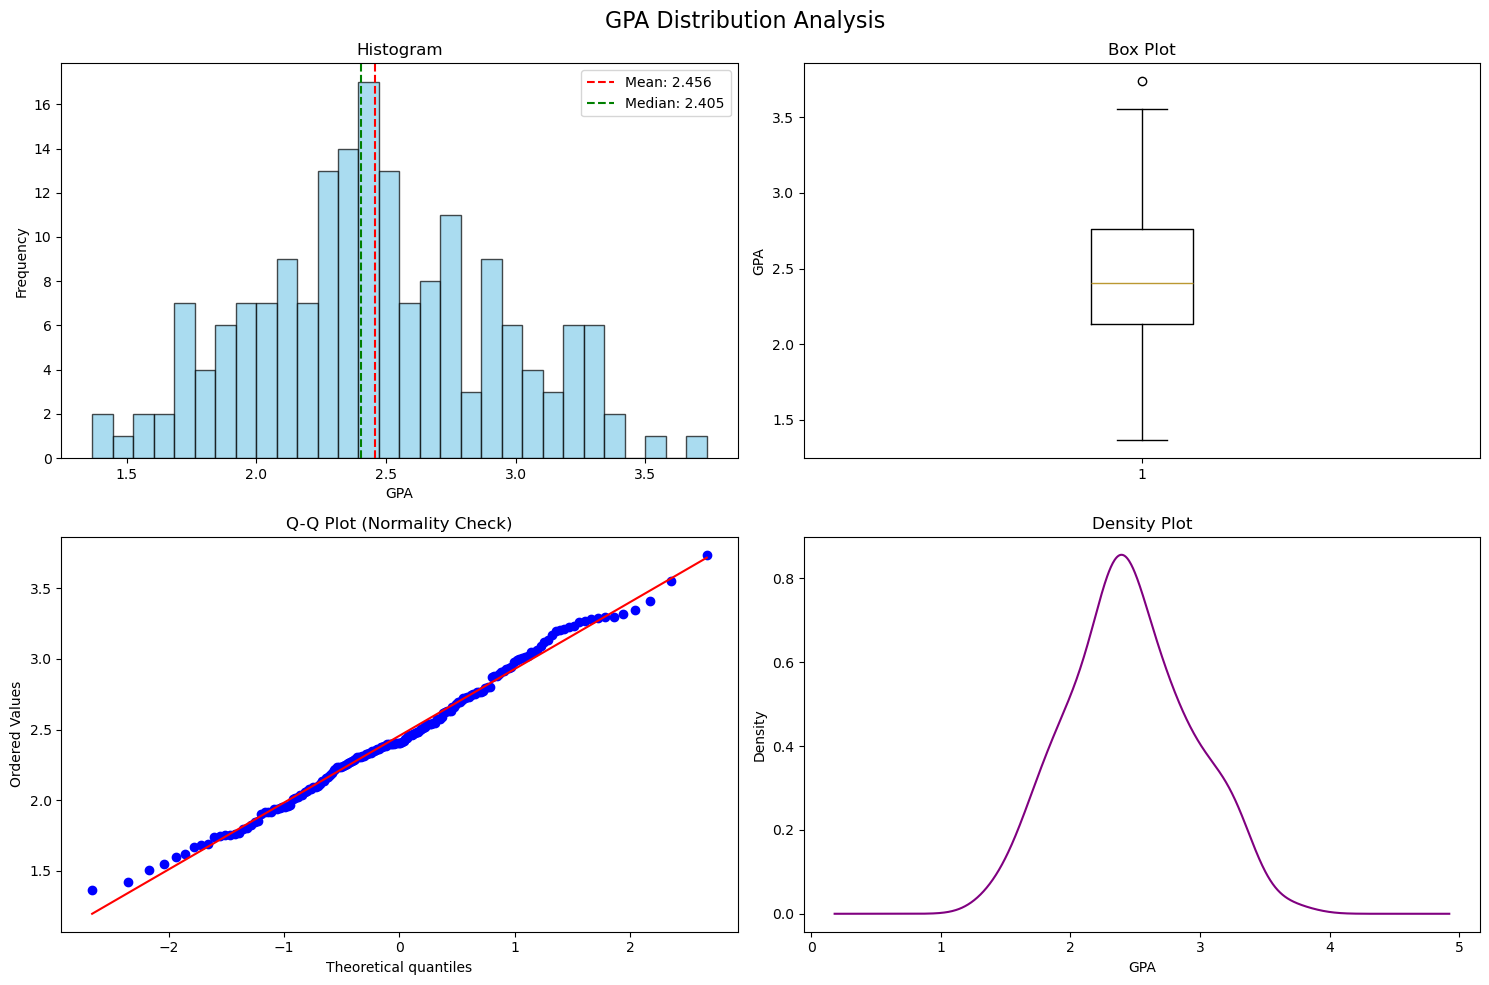


Normality Tests:
Shapiro-Wilk p-value: 0.403814
Distribution is Normal (α = 0.05)

=== STEP 3: NUMERICAL VARIABLES ANALYSIS ===
Numerical variables: ['prev_gpa', 'STUDENTS', 'TEACHERS', 'STUDENT-TEACHER RATIO', 'studying_hours', 'teacher_qualification', 'number_of_books']

3.1 CORRELATION ANALYSIS:
Correlation with GPA:
  prev_gpa: 0.756
  studying_hours: 0.688
  number_of_books: 0.683
  STUDENTS: 0.062
  TEACHERS: 0.010
  STUDENT-TEACHER RATIO: nan
  teacher_qualification: nan


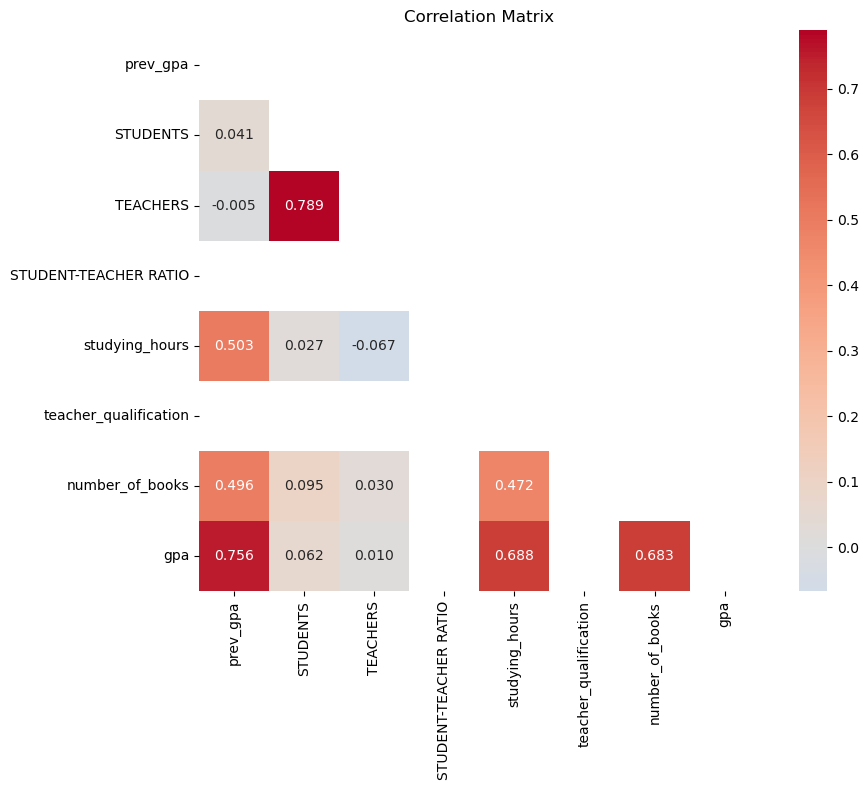

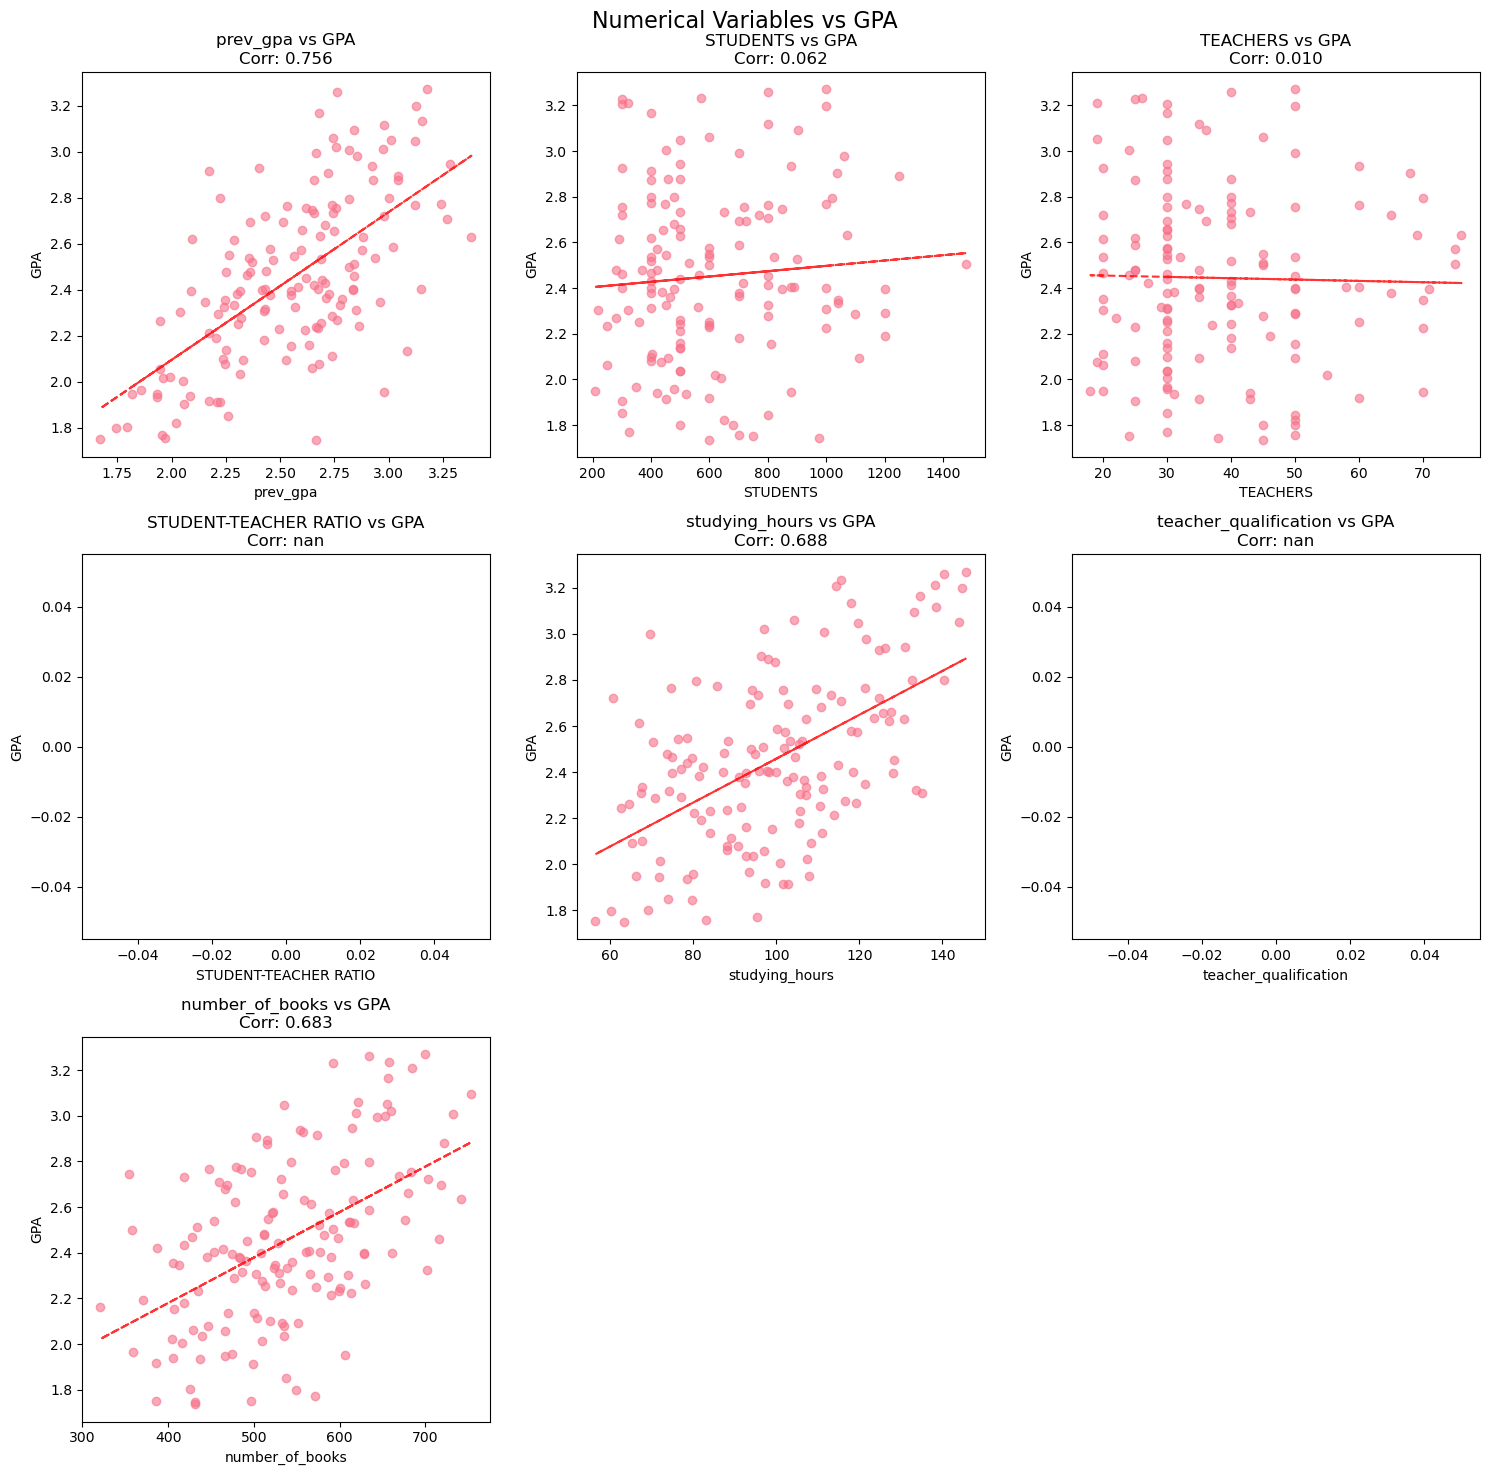


=== STEP 4: CATEGORICAL VARIABLES ANALYSIS ===
Categorical variables: ['SCHOOL OWNERSHIP', 'SCHOOL CATEGORY', 'SCHOOL TYPE', 'COMBINATIONS CATEGORY', 'ACADEMIC LEVEL CATEGORY']

4.1 ANALYSIS OF SCHOOL OWNERSHIP:
Categories (2 unique):
SCHOOL OWNERSHIP
PRIVATE       130
GOVERNMENT     48
Name: count, dtype: int64
Missing values: 0 (0.0%)
ANOVA F-statistic: 1.368, p-value: 0.243726
Significant difference: No (α = 0.05)


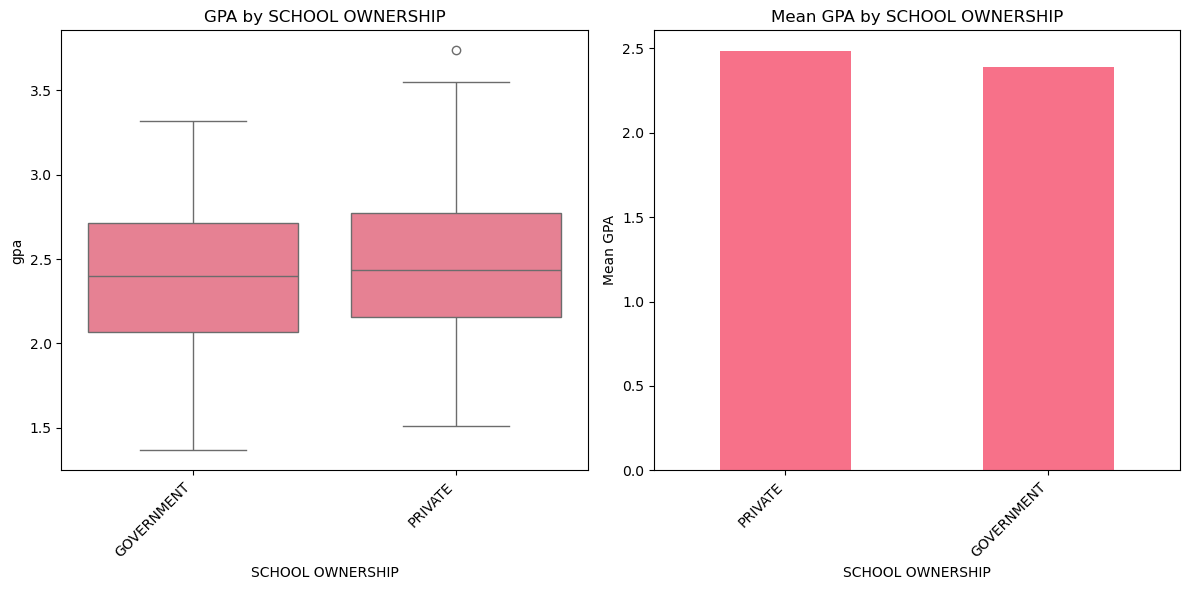


Summary statistics by SCHOOL OWNERSHIP:
                  count   mean    std    min    max
SCHOOL OWNERSHIP                                   
GOVERNMENT           48  2.388  0.512  1.366  3.318
PRIVATE             130  2.481  0.454  1.508  3.738

4.2 ANALYSIS OF SCHOOL CATEGORY:
Categories (3 unique):
SCHOOL CATEGORY
BOYS AND GIRLS    111
GIRLS ONLY         38
BOYS ONLY          29
Name: count, dtype: int64
Missing values: 0 (0.0%)
ANOVA F-statistic: 1.376, p-value: 0.255204
Significant difference: No (α = 0.05)


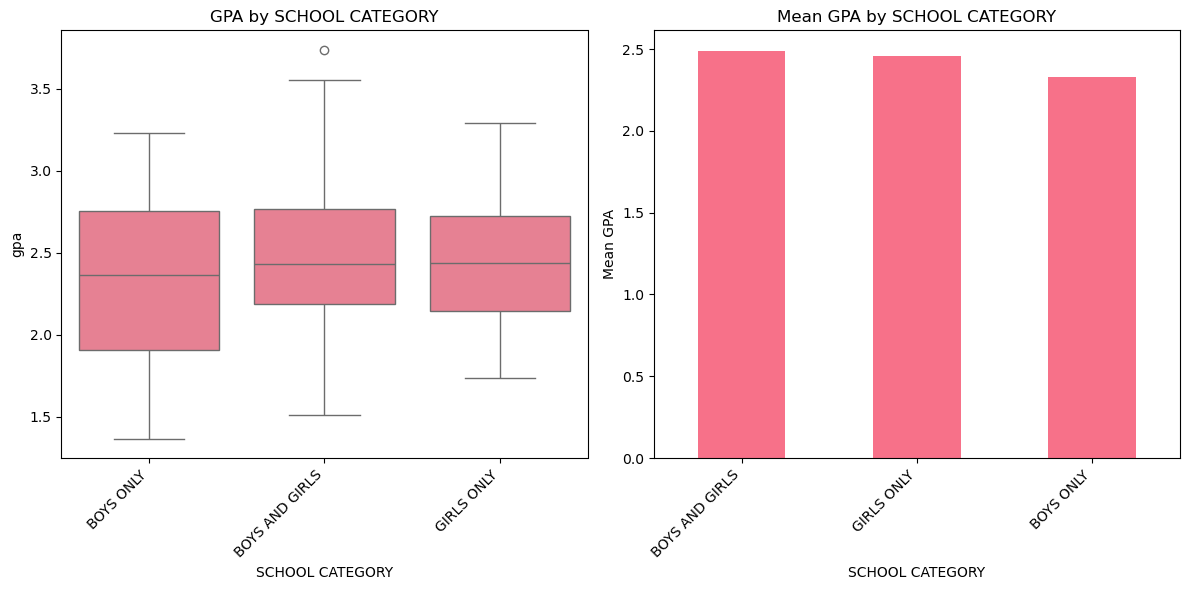


Summary statistics by SCHOOL CATEGORY:
                 count   mean    std    min    max
SCHOOL CATEGORY                                   
BOYS AND GIRLS     111  2.490  0.448  1.508  3.738
BOYS ONLY           29  2.327  0.536  1.366  3.229
GIRLS ONLY          38  2.456  0.481  1.737  3.292

4.3 ANALYSIS OF SCHOOL TYPE:
Categories (3 unique):
SCHOOL TYPE
BOARDING            106
DAY AND BOARDING     62
DAY                   5
Name: count, dtype: int64
Missing values: 5 (2.8%)
ANOVA F-statistic: 1.157, p-value: 0.316771
Significant difference: No (α = 0.05)


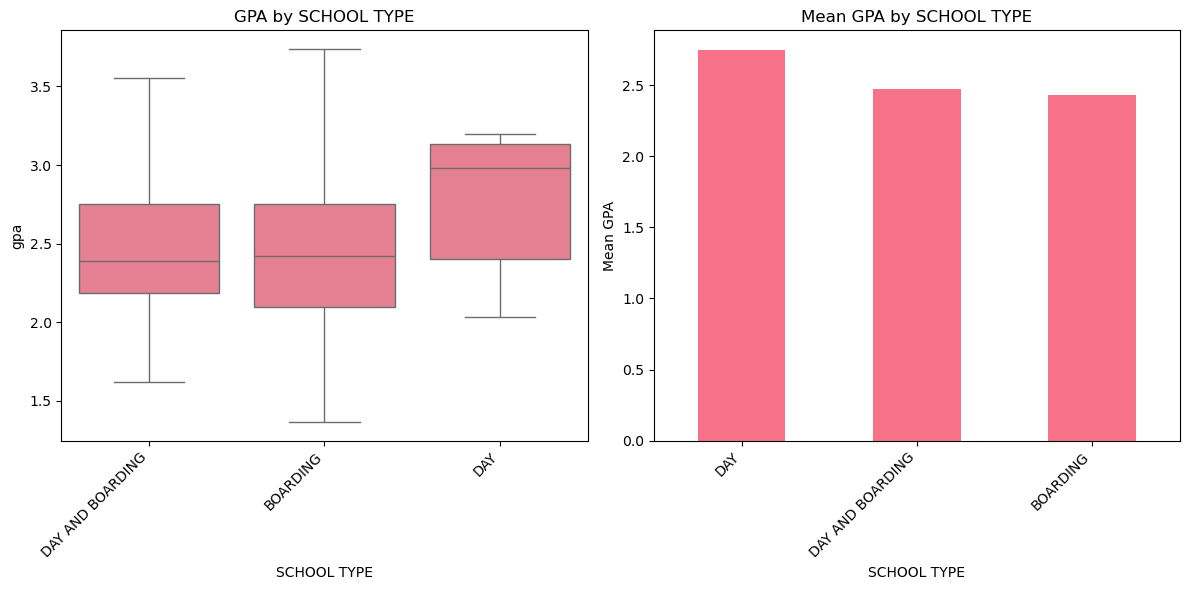


Summary statistics by SCHOOL TYPE:
                  count   mean    std    min    max
SCHOOL TYPE                                        
BOARDING            106  2.432  0.476  1.366  3.738
DAY                   5  2.750  0.508  2.035  3.197
DAY AND BOARDING     62  2.473  0.453  1.618  3.552

4.4 ANALYSIS OF COMBINATIONS CATEGORY:
Categories (3 unique):
COMBINATIONS CATEGORY
MIXED      135
ARTS        24
SCIENCE      8
Name: count, dtype: int64
Missing values: 11 (6.2%)
ANOVA F-statistic: 3.239, p-value: 0.041708
Significant difference: Yes (α = 0.05)


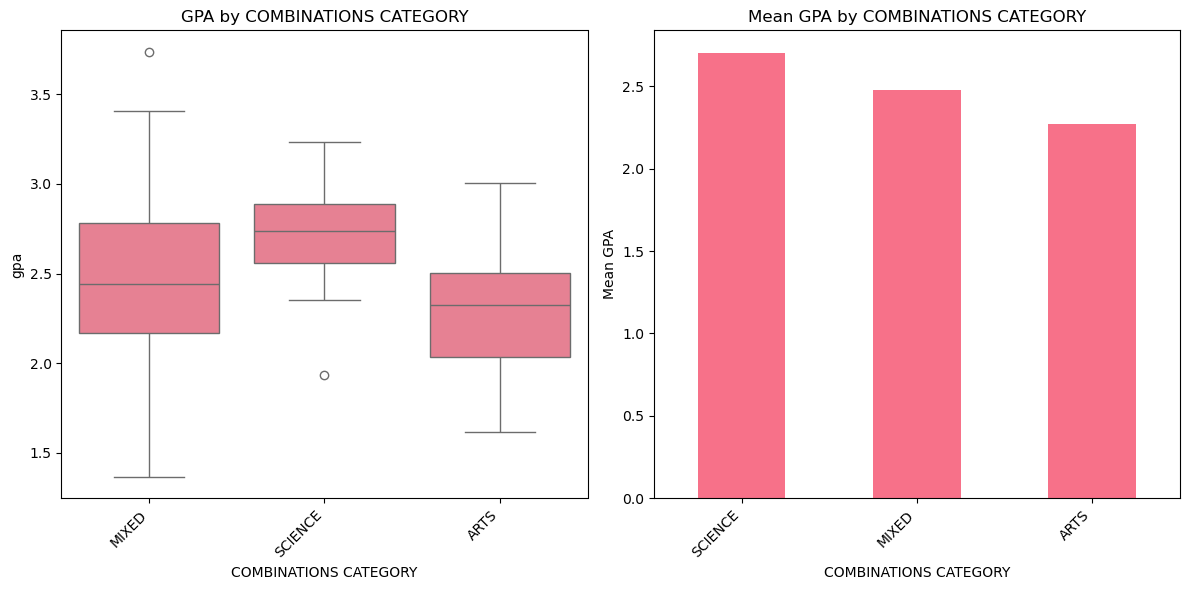


Summary statistics by COMBINATIONS CATEGORY:
                       count   mean    std    min    max
COMBINATIONS CATEGORY                                   
ARTS                      24  2.268  0.373  1.618  3.007
MIXED                    135  2.475  0.478  1.366  3.738
SCIENCE                    8  2.704  0.428  1.936  3.233

4.5 ANALYSIS OF ACADEMIC LEVEL CATEGORY:
Categories (2 unique):
ACADEMIC LEVEL CATEGORY
COMBINED OA    149
ALEVEL ONLY     18
Name: count, dtype: int64
Missing values: 11 (6.2%)
ANOVA F-statistic: 2.612, p-value: 0.107986
Significant difference: No (α = 0.05)


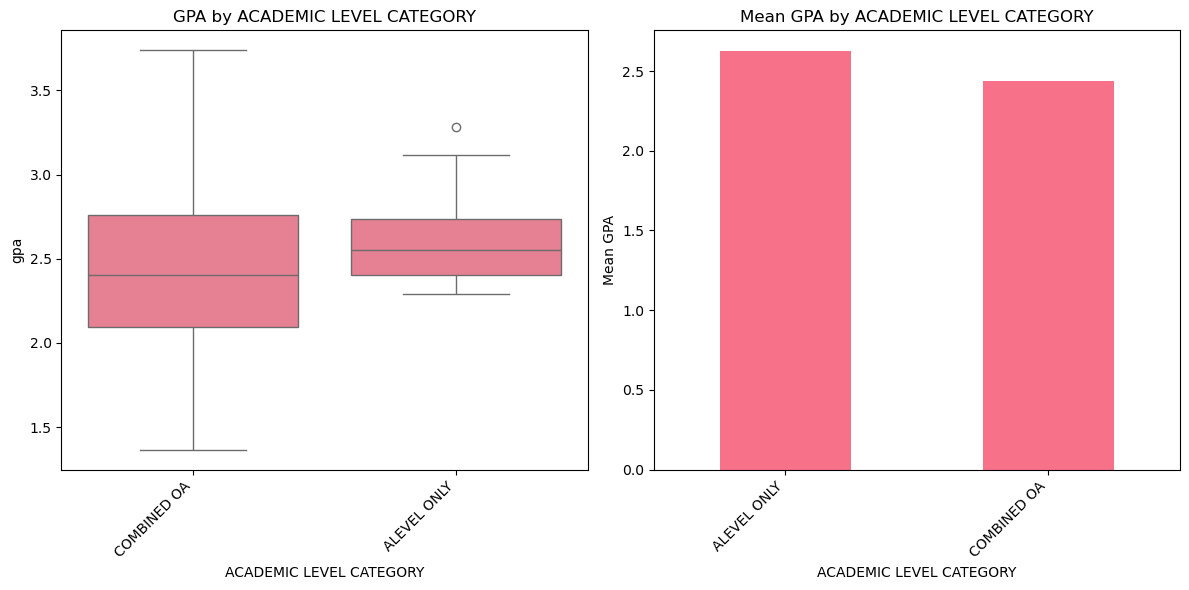


Summary statistics by ACADEMIC LEVEL CATEGORY:
                         count   mean    std    min    max
ACADEMIC LEVEL CATEGORY                                   
ALEVEL ONLY                 18  2.624  0.299  2.293  3.282
COMBINED OA                149  2.436  0.482  1.366  3.738

=== STEP 5: MULTIVARIATE ANALYSIS ===
5.1 PREDICTOR CORRELATIONS:
High correlations between predictors (|r| > 0.7):
  prev_sat - sat: 0.969
  STUDENTS - TEACHERS: 0.789

5.2 INTERACTION EFFECTS:


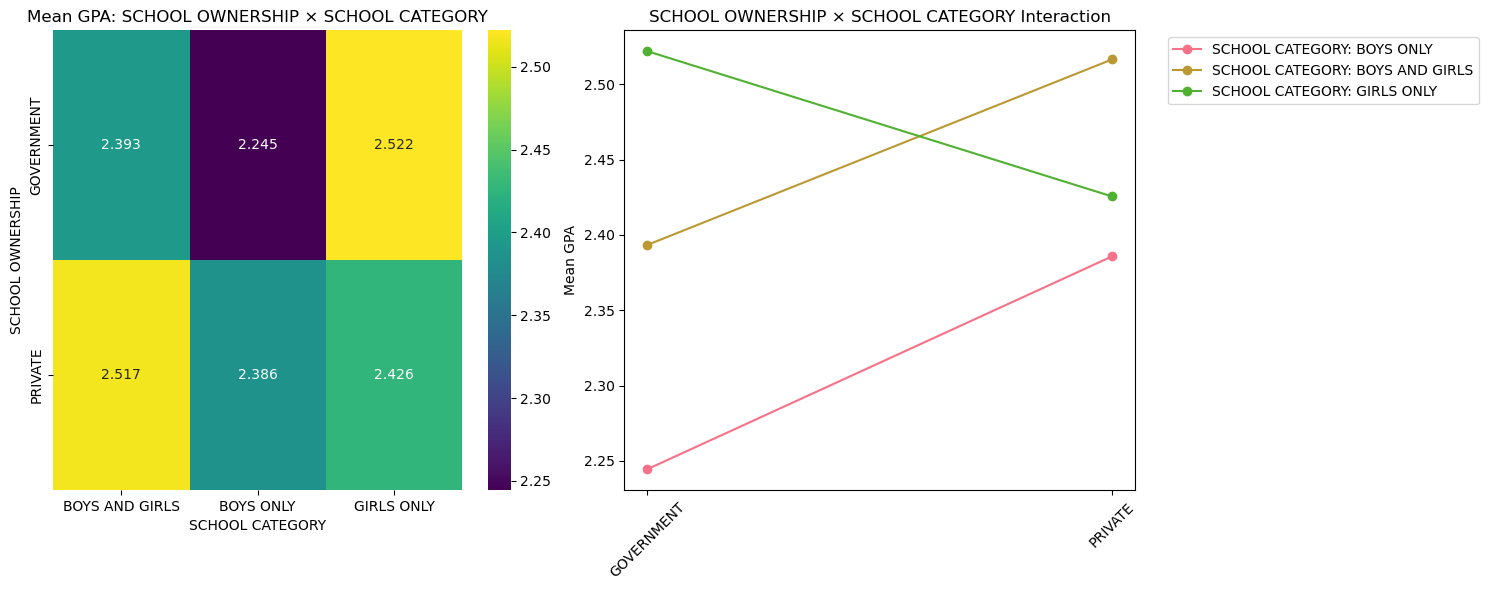


=== STEP 6: DATA QUALITY ASSESSMENT ===
6.1 MISSING DATA ANALYSIS:
                         Missing_Count  Missing_Percentage
STUDENT-TEACHER RATIO              178          100.000000
teacher_qualification              178          100.000000
COMBINATIONS CATEGORY               11            6.179775
ACADEMIC LEVEL CATEGORY             11            6.179775
SCHOOL TYPE                          5            2.808989
prev_gpa                             1            0.561798


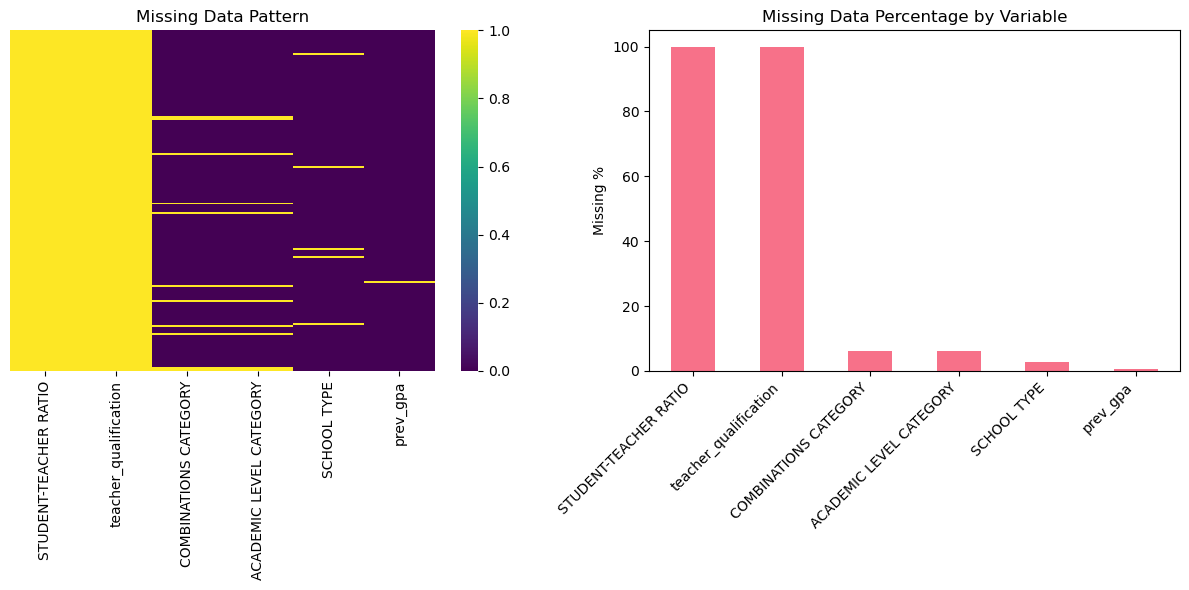


6.2 OUTLIER ANALYSIS:
Skipping STUDENT-TEACHER RATIO: No valid data
Skipping teacher_qualification: No valid data
Outliers by variable:
                 count  percentage  valid_observations
prev_sat          18.0   10.112360               178.0
sat               18.0   10.112360               178.0
STUDENTS          10.0    5.617978               178.0
TEACHERS           6.0    3.370787               178.0
number_of_books    3.0    1.685393               178.0
prev_gpa           1.0    0.564972               177.0
gpa                1.0    0.561798               178.0
studying_hours     1.0    0.561798               178.0

=== STEP 7: FEATURE ENGINEERING SUGGESTIONS ===
7.1 POTENTIAL NEW FEATURES:
- Student-Teacher ratio (if not already present)
- SAT improvement (current - previous)
- SAT improvement percentage
- GPA improvement (current - previous)
- GPA improvement percentage

7.2 TRANSFORMATION SUGGESTIONS:
- prev_sat: highly skewed (1.81), consider log transformation
- sat: high

In [10]:
# Run complete EDA
df_clean = run_comprehensive_eda(df)

# # Or run individual steps
# df_model = prepare_data(df)
# analyze_target_variable(df_model)
# correlations = analyze_numerical_variables(df_model)
# analyze_categorical_variables(df_model)

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
import warnings
warnings.filterwarnings('ignore')

# ==========================================
# MISSING DATA ANALYSIS & STRATEGY
# ==========================================

def analyze_missing_patterns(df):
    """
    Comprehensive analysis of missing data patterns
    """
    print("=== MISSING DATA PATTERN ANALYSIS ===")
    
    # Focus on model variables
    model_vars = ['prev_sat', 'SCHOOL OWNERSHIP', 'SCHOOL CATEGORY', 'SCHOOL TYPE',
                  'COMBINATIONS CATEGORY', 'ACADEMIC LEVEL CATEGORY', 'prev_gpa', 
                  'gpa', 'sat', 'STUDENTS', 'TEACHERS', 'STUDENT-TEACHER RATIO']
    
    # Only include variables that exist
    available_vars = [var for var in model_vars if var in df.columns]
    df_model = df[available_vars].copy()
    
    # Convert numeric columns
    numeric_cols = ['prev_gpa', 'STUDENTS', 'TEACHERS', 'STUDENT-TEACHER RATIO']
    for col in numeric_cols:
        if col in df_model.columns:
            df_model[col] = pd.to_numeric(df_model[col], errors='coerce')
    
    # Missing data summary
    missing_summary = pd.DataFrame({
        'Variable': df_model.columns,
        'Missing_Count': df_model.isnull().sum(),
        'Missing_Percentage': (df_model.isnull().sum() / len(df_model)) * 100,
        'Data_Type': [df_model[col].dtype for col in df_model.columns],
        'Unique_Values': [df_model[col].nunique() for col in df_model.columns]
    }).sort_values('Missing_Percentage', ascending=False)
    
    print("MISSING DATA SUMMARY:")
    print(missing_summary)
    
    # Categorize missing data severity
    print("\n=== MISSING DATA SEVERITY CATEGORIES ===")
    
    high_missing = missing_summary[missing_summary['Missing_Percentage'] > 70]
    medium_missing = missing_summary[(missing_summary['Missing_Percentage'] > 30) & 
                                   (missing_summary['Missing_Percentage'] <= 70)]
    low_missing = missing_summary[(missing_summary['Missing_Percentage'] > 0) & 
                                (missing_summary['Missing_Percentage'] <= 30)]
    complete_vars = missing_summary[missing_summary['Missing_Percentage'] == 0]
    
    print(f"🔴 HIGH MISSING (>70%): {len(high_missing)} variables")
    if len(high_missing) > 0:
        print(high_missing[['Variable', 'Missing_Percentage']].to_string(index=False))
    
    print(f"\n🟡 MEDIUM MISSING (30-70%): {len(medium_missing)} variables")
    if len(medium_missing) > 0:
        print(medium_missing[['Variable', 'Missing_Percentage']].to_string(index=False))
    
    print(f"\n🟢 LOW MISSING (<30%): {len(low_missing)} variables")
    if len(low_missing) > 0:
        print(low_missing[['Variable', 'Missing_Percentage']].to_string(index=False))
    
    print(f"\n✅ COMPLETE VARIABLES: {len(complete_vars)} variables")
    if len(complete_vars) > 0:
        print(complete_vars[['Variable']].to_string(index=False))
    
    # Missing data visualization
    plt.figure(figsize=(15, 10))
    
    # Missing data heatmap
    plt.subplot(2, 2, 1)
    sns.heatmap(df_model.isnull(), cbar=True, yticklabels=False, cmap='viridis')
    plt.title('Missing Data Pattern')
    
    # Missing percentage bar plot
    plt.subplot(2, 2, 2)
    missing_pct = missing_summary[missing_summary['Missing_Percentage'] > 0]
    plt.barh(missing_pct['Variable'], missing_pct['Missing_Percentage'])
    plt.xlabel('Missing Percentage')
    plt.title('Missing Data by Variable')
    
    # Missing data co-occurrence
    plt.subplot(2, 2, 3)
    # Create missing data correlation matrix
    missing_df = df_model.isnull().astype(int)
    missing_corr = missing_df.corr()
    sns.heatmap(missing_corr, annot=True, cmap='coolwarm', center=0, fmt='.2f')
    plt.title('Missing Data Co-occurrence')
    
    # Complete cases analysis
    plt.subplot(2, 2, 4)
    complete_cases = df_model.dropna().shape[0]
    total_cases = df_model.shape[0]
    incomplete_cases = total_cases - complete_cases
    
    plt.pie([complete_cases, incomplete_cases], 
            labels=[f'Complete ({complete_cases})', f'Incomplete ({incomplete_cases})'],
            autopct='%1.1f%%')
    plt.title('Complete vs Incomplete Cases')
    
    plt.tight_layout()
    plt.show()
    
    return df_model, missing_summary

def create_missing_data_strategy(missing_summary):
    """
    Create comprehensive strategy for handling missing data
    """
    print("\n=== MISSING DATA HANDLING STRATEGY ===")
    
    strategies = []
    
    for _, row in missing_summary.iterrows():
        var = row['Variable']
        missing_pct = row['Missing_Percentage']
        data_type = row['Data_Type']
        
        if missing_pct == 0:
            strategy = "✅ No action needed"
        elif missing_pct > 80:
            strategy = "🗑️  DROP VARIABLE - Too much missing data"
        elif missing_pct > 50:
            if 'object' in str(data_type):
                strategy = "🏷️  CREATE 'MISSING' CATEGORY + Drop/Impute"
            else:
                strategy = "📊 DROP VARIABLE or ADVANCED IMPUTATION only"
        elif missing_pct > 30:
            if 'object' in str(data_type):
                strategy = "🎯 MODE IMPUTATION or CREATE 'MISSING' CATEGORY"
            else:
                strategy = "🔢 MEDIAN/KNN IMPUTATION"
        else:  # missing_pct <= 30
            if 'object' in str(data_type):
                strategy = "🎯 MODE IMPUTATION"
            else:
                strategy = "🔢 MEAN/MEDIAN IMPUTATION"
        
        strategies.append({
            'Variable': var,
            'Missing_Pct': missing_pct,
            'Data_Type': data_type,
            'Recommended_Strategy': strategy
        })
    
    strategy_df = pd.DataFrame(strategies)
    print(strategy_df.to_string(index=False))
    
    return strategy_df

def implement_missing_data_solutions(df, strategy='comprehensive'):
    """
    Implement missing data handling solutions
    """
    print(f"\n=== IMPLEMENTING MISSING DATA SOLUTIONS ({strategy.upper()}) ===")
    
    # Focus on model variables
    model_vars = ['prev_sat', 'SCHOOL OWNERSHIP', 'SCHOOL CATEGORY', 'SCHOOL TYPE',
                  'COMBINATIONS CATEGORY', 'ACADEMIC LEVEL CATEGORY', 'prev_gpa', 
                  'gpa', 'sat', 'STUDENTS', 'TEACHERS', 'STUDENT-TEACHER RATIO']
    
    available_vars = [var for var in model_vars if var in df.columns]
    df_processed = df[available_vars].copy()
    
    # Convert numeric columns
    numeric_cols = ['prev_gpa', 'STUDENTS', 'TEACHERS', 'STUDENT-TEACHER RATIO']
    for col in numeric_cols:
        if col in df_processed.columns:
            df_processed[col] = pd.to_numeric(df_processed[col], errors='coerce')
    
    print("BEFORE PROCESSING:")
    print(df_processed.isnull().sum())
    print(f"Complete cases: {df_processed.dropna().shape[0]} / {df_processed.shape[0]}")
    
    if strategy == 'conservative':
        return implement_conservative_strategy(df_processed)
    elif strategy == 'aggressive':
        return implement_aggressive_strategy(df_processed)
    else:  # comprehensive
        return implement_comprehensive_strategy(df_processed)

def implement_conservative_strategy(df):
    """
    Conservative approach: Only use complete cases for high-missing variables
    """
    print("\n--- CONSERVATIVE STRATEGY ---")
    print("• Drop variables with >50% missing")
    print("• Simple imputation for <50% missing")
    print("• Preserve original data structure")
    
    df_conservative = df.copy()
    
    # Drop variables with >50% missing
    missing_pct = (df.isnull().sum() / len(df)) * 100
    high_missing_vars = missing_pct[missing_pct > 50].index.tolist()
    
    if high_missing_vars:
        print(f"Dropping variables: {high_missing_vars}")
        df_conservative = df_conservative.drop(columns=high_missing_vars)
    
    # Simple imputation for remaining variables
    for col in df_conservative.columns:
        if df_conservative[col].isnull().any():
            if df_conservative[col].dtype == 'object':
                # Mode imputation for categorical
                mode_val = df_conservative[col].mode()
                if len(mode_val) > 0:
                    df_conservative[col].fillna(mode_val[0], inplace=True)
                    print(f"Imputed {col} with mode: {mode_val[0]}")
            else:
                # Median imputation for numerical
                median_val = df_conservative[col].median()
                df_conservative[col].fillna(median_val, inplace=True)
                print(f"Imputed {col} with median: {median_val:.2f}")
    
    print(f"\nFINAL DATASET SHAPE: {df_conservative.shape}")
    print(f"Variables retained: {list(df_conservative.columns)}")
    print("Missing values after processing:")
    print(df_conservative.isnull().sum())
    
    return df_conservative

def implement_aggressive_strategy(df):
    """
    Aggressive approach: Advanced imputation techniques
    """
    print("\n--- AGGRESSIVE STRATEGY ---")
    print("• Keep all variables")
    print("• Advanced imputation (KNN, Iterative)")
    print("• Create missing indicators")
    
    df_aggressive = df.copy()
    
    # Separate numerical and categorical columns
    numerical_cols = df_aggressive.select_dtypes(include=[np.number]).columns.tolist()
    categorical_cols = df_aggressive.select_dtypes(include=['object']).columns.tolist()
    
    # Create missing indicators for variables with >20% missing
    missing_pct = (df.isnull().sum() / len(df)) * 100
    high_missing_vars = missing_pct[missing_pct > 20].index.tolist()
    
    for var in high_missing_vars:
        df_aggressive[f'{var}_was_missing'] = df_aggressive[var].isnull().astype(int)
        print(f"Created missing indicator for {var}")
    
    # Advanced imputation for numerical variables
    if numerical_cols:
        print(f"Applying KNN imputation to numerical variables: {numerical_cols}")
        imputer = KNNImputer(n_neighbors=5)
        df_aggressive[numerical_cols] = imputer.fit_transform(df_aggressive[numerical_cols])
    
    # Mode imputation for categorical variables
    for col in categorical_cols:
        if df_aggressive[col].isnull().any():
            missing_count = df_aggressive[col].isnull().sum()
            missing_pct = (missing_count / len(df_aggressive)) * 100
            
            if missing_pct > 30:
                # Create 'Unknown' category for high missing
                df_aggressive[col].fillna('Unknown', inplace=True)
                print(f"Created 'Unknown' category for {col} ({missing_pct:.1f}% missing)")
            else:
                # Mode imputation for low missing
                mode_val = df_aggressive[col].mode()
                if len(mode_val) > 0:
                    df_aggressive[col].fillna(mode_val[0], inplace=True)
                    print(f"Imputed {col} with mode: {mode_val[0]}")
    
    print(f"\nFINAL DATASET SHAPE: {df_aggressive.shape}")
    print("Missing values after processing:")
    print(df_aggressive.isnull().sum())
    
    return df_aggressive

def implement_comprehensive_strategy(df):
    """
    Comprehensive approach: Balanced strategy based on data patterns
    """
    print("\n--- COMPREHENSIVE STRATEGY ---")
    print("• Variable-specific strategies based on missing patterns")
    print("• Balanced approach between data retention and quality")
    
    df_comprehensive = df.copy()
    
    # Calculate missing percentages
    missing_pct = (df.isnull().sum() / len(df)) * 100
    
    # Strategy by variable
    for col in df_comprehensive.columns:
        missing_rate = missing_pct[col]
        
        if missing_rate == 0:
            continue
        elif missing_rate > 80:
            print(f"🗑️  DROPPING {col}: {missing_rate:.1f}% missing (too high)")
            df_comprehensive = df_comprehensive.drop(columns=[col])
        elif missing_rate > 50:
            if df_comprehensive[col].dtype == 'object':
                df_comprehensive[col].fillna('Missing_Data', inplace=True)
                print(f"🏷️  {col}: Created 'Missing_Data' category ({missing_rate:.1f}% missing)")
            else:
                print(f"⚠️  {col}: High missing rate ({missing_rate:.1f}%) - consider dropping")
        elif missing_rate > 20:
            if df_comprehensive[col].dtype == 'object':
                # For categorical with medium missing, use mode or create category
                unique_count = df_comprehensive[col].nunique()
                if unique_count <= 10:
                    mode_val = df_comprehensive[col].mode()
                    if len(mode_val) > 0:
                        df_comprehensive[col].fillna(mode_val[0], inplace=True)
                        print(f"🎯 {col}: Mode imputation with '{mode_val[0]}'")
                else:
                    df_comprehensive[col].fillna('Other', inplace=True)
                    print(f"🏷️  {col}: Created 'Other' category")
            else:
                # For numerical with medium missing, use median
                median_val = df_comprehensive[col].median()
                df_comprehensive[col].fillna(median_val, inplace=True)
                print(f"🔢 {col}: Median imputation ({median_val:.2f})")
        else:  # missing_rate <= 20
            if df_comprehensive[col].dtype == 'object':
                mode_val = df_comprehensive[col].mode()
                if len(mode_val) > 0:
                    df_comprehensive[col].fillna(mode_val[0], inplace=True)
                    print(f"🎯 {col}: Mode imputation with '{mode_val[0]}'")
            else:
                mean_val = df_comprehensive[col].mean()
                df_comprehensive[col].fillna(mean_val, inplace=True)
                print(f"🔢 {col}: Mean imputation ({mean_val:.2f})")
    
    print(f"\nFINAL DATASET SHAPE: {df_comprehensive.shape}")
    print("Missing values after processing:")
    remaining_missing = df_comprehensive.isnull().sum()
    print(remaining_missing[remaining_missing > 0])
    
    if remaining_missing.sum() == 0:
        print("✅ All missing values handled successfully!")
    
    return df_comprehensive

def compare_strategies(df):
    """
    Compare different missing data strategies
    """
    print("\n=== STRATEGY COMPARISON ===")
    
    # Implement all strategies
    df_conservative = implement_conservative_strategy(df)
    df_aggressive = implement_aggressive_strategy(df)
    df_comprehensive = implement_comprehensive_strategy(df)
    
    comparison = pd.DataFrame({
        'Strategy': ['Original', 'Conservative', 'Aggressive', 'Comprehensive'],
        'Rows': [df.shape[0], df_conservative.shape[0], df_aggressive.shape[0], df_comprehensive.shape[0]],
        'Columns': [df.shape[1], df_conservative.shape[1], df_aggressive.shape[1], df_comprehensive.shape[1]],
        'Complete_Cases': [
            df.dropna().shape[0],
            df_conservative.dropna().shape[0],
            df_aggressive.dropna().shape[0],
            df_comprehensive.dropna().shape[0]
        ],
        'Missing_Values': [
            df.isnull().sum().sum(),
            df_conservative.isnull().sum().sum(),
            df_aggressive.isnull().sum().sum(),
            df_comprehensive.isnull().sum().sum()
        ]
    })
    
    comparison['Completeness_Rate'] = (comparison['Complete_Cases'] / comparison['Rows'] * 100).round(1)
    
    print(comparison)
    
    return {
        'conservative': df_conservative,
        'aggressive': df_aggressive,
        'comprehensive': df_comprehensive,
        'comparison': comparison
    }

# ==========================================
# RECOMMENDATION BASED ON YOUR DATA
# ==========================================

def get_recommendation_for_gpa_prediction(df):
    """
    Specific recommendation for GPA prediction based on your data patterns
    """
    print("\n=== SPECIFIC RECOMMENDATION FOR YOUR GPA PREDICTION ===")
    
    model_vars = ['prev_sat', 'SCHOOL OWNERSHIP', 'SCHOOL CATEGORY', 'SCHOOL TYPE',
                  'COMBINATIONS CATEGORY', 'ACADEMIC LEVEL CATEGORY', 'prev_gpa', 
                  'gpa', 'sat', 'STUDENTS', 'TEACHERS', 'STUDENT-TEACHER RATIO']
    
    available_vars = [var for var in model_vars if var in df.columns]
    df_model = df[available_vars].copy()
    
    # Convert numeric columns
    numeric_cols = ['prev_gpa', 'STUDENTS', 'TEACHERS', 'STUDENT-TEACHER RATIO']
    for col in numeric_cols:
        if col in df_model.columns:
            df_model[col] = pd.to_numeric(df_model[col], errors='coerce')
    
    missing_pct = (df_model.isnull().sum() / len(df_model)) * 100
    
    print("📊 BASED ON YOUR DATA PATTERN:")
    print(f"• Total schools: {len(df_model)}")
    print(f"• Schools with complete current data: ~929 (98%)")
    print(f"• Schools with historical data: ~877 (92%)")
    print(f"• Schools with institutional details: ~191 (20%)")
    
    print("\n🎯 RECOMMENDED APPROACH:")
    print("1. **TWO-TIER MODELING STRATEGY**")
    print("   - Tier 1: Use 929 schools with current performance data")
    print("   - Tier 2: Use 191 schools with full institutional data")
    
    print("\n2. **VARIABLE-SPECIFIC HANDLING:**")
    print("   - Keep: gpa, sat, prev_sat, prev_gpa (low missing)")
    print("   - Transform: School characteristics (create 'Unknown' categories)")
    print("   - Consider dropping: STUDENTS, TEACHERS ratios (80% missing)")
    
    print("\n3. **RECOMMENDED PREPROCESSING:**")
    print("   - Primary model: Focus on performance variables")
    print("   - Enhanced model: Include institutional variables for subset")
    print("   - Create ensemble combining both approaches")
    
    return missing_pct

# ==========================================
# MAIN EXECUTION
# ==========================================

def run_missing_data_analysis(df):
    """
    Run complete missing data analysis and provide recommendations
    """
    print("🔍 COMPREHENSIVE MISSING DATA ANALYSIS FOR GPA PREDICTION")
    print("=" * 60)
    
    # Step 1: Analyze missing patterns
    df_model, missing_summary = analyze_missing_patterns(df)
    
    # Step 2: Create strategy
    strategy_df = create_missing_data_strategy(missing_summary)
    
    # Step 3: Get specific recommendation
    recommendation = get_recommendation_for_gpa_prediction(df)
    
    # Step 4: Compare strategies (optional)
    print("\n" + "="*50)
    print("Would you like to see strategy comparison? (This will process the data)")
    
    return df_model, missing_summary, strategy_df

# Usage:
# df_model, missing_summary, strategy_df = run_missing_data_analysis(df)
# 
# To implement a specific strategy:
# df_processed = implement_missing_data_solutions(df, strategy='comprehensive')
# 
# To compare all strategies:
# results = compare_strategies(df_model)

🔍 COMPREHENSIVE MISSING DATA ANALYSIS FOR GPA PREDICTION
=== MISSING DATA PATTERN ANALYSIS ===
MISSING DATA SUMMARY:
                                        Variable  Missing_Count  \
STUDENT-TEACHER RATIO      STUDENT-TEACHER RATIO            178   
COMBINATIONS CATEGORY      COMBINATIONS CATEGORY             11   
ACADEMIC LEVEL CATEGORY  ACADEMIC LEVEL CATEGORY             11   
SCHOOL TYPE                          SCHOOL TYPE              5   
prev_gpa                                prev_gpa              1   
prev_sat                                prev_sat              0   
SCHOOL OWNERSHIP                SCHOOL OWNERSHIP              0   
SCHOOL CATEGORY                  SCHOOL CATEGORY              0   
gpa                                          gpa              0   
sat                                          sat              0   
STUDENTS                                STUDENTS              0   
TEACHERS                                TEACHERS              0   

           

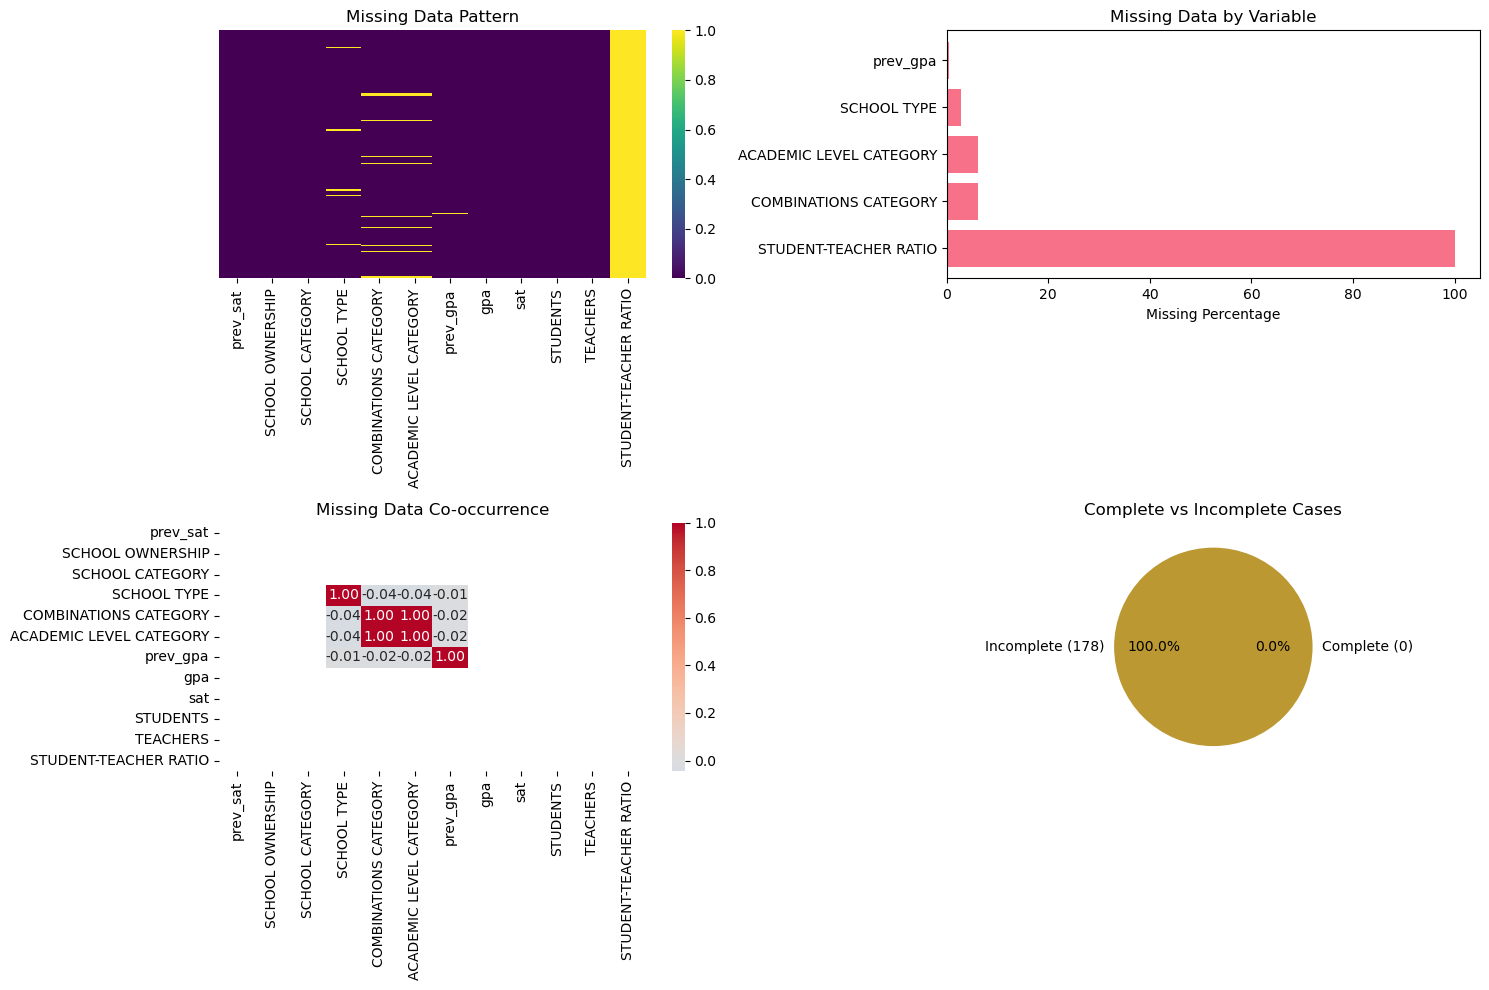


=== MISSING DATA HANDLING STRATEGY ===
               Variable  Missing_Pct Data_Type                      Recommended_Strategy
  STUDENT-TEACHER RATIO   100.000000   float64 🗑️  DROP VARIABLE - Too much missing data
  COMBINATIONS CATEGORY     6.179775    object                         🎯 MODE IMPUTATION
ACADEMIC LEVEL CATEGORY     6.179775    object                         🎯 MODE IMPUTATION
            SCHOOL TYPE     2.808989    object                         🎯 MODE IMPUTATION
               prev_gpa     0.561798   float64                  🔢 MEAN/MEDIAN IMPUTATION
               prev_sat     0.000000   float64                        ✅ No action needed
       SCHOOL OWNERSHIP     0.000000    object                        ✅ No action needed
        SCHOOL CATEGORY     0.000000    object                        ✅ No action needed
                    gpa     0.000000   float64                        ✅ No action needed
                    sat     0.000000   float64                        

In [12]:
df_model, missing_summary, strategy_df = run_missing_data_analysis(df)

In [41]:
# Comprehensive approach (recommended)
df_processed = implement_missing_data_solutions(df, strategy='comprehensive')

# Or compare all strategies
results = compare_strategies(df_model)


=== IMPLEMENTING MISSING DATA SOLUTIONS (COMPREHENSIVE) ===
BEFORE PROCESSING:
prev_sat                    71
SCHOOL OWNERSHIP           757
SCHOOL CATEGORY            757
SCHOOL TYPE                762
COMBINATIONS CATEGORY      769
ACADEMIC LEVEL CATEGORY    769
prev_gpa                    74
gpa                         19
sat                         19
STUDENTS                   760
TEACHERS                   760
STUDENT-TEACHER RATIO      948
dtype: int64
Complete cases: 0 / 948

--- COMPREHENSIVE STRATEGY ---
• Variable-specific strategies based on missing patterns
• Balanced approach between data retention and quality
🔢 prev_sat: Mean imputation (109.66)
🏷️  SCHOOL OWNERSHIP: Created 'Missing_Data' category (79.9% missing)
🏷️  SCHOOL CATEGORY: Created 'Missing_Data' category (79.9% missing)
🗑️  DROPPING SCHOOL TYPE: 80.4% missing (too high)
🗑️  DROPPING COMBINATIONS CATEGORY: 81.1% missing (too high)
🗑️  DROPPING ACADEMIC LEVEL CATEGORY: 81.1% missing (too high)
🔢 prev_gpa: Mean

ValueError: Columns must be same length as key

In [42]:
results

NameError: name 'results' is not defined